<a href="https://colab.research.google.com/github/fernandabarrigosse/LIA/blob/main/trab1RNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install torch torchvision scikit-learn matplotlib seaborn --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo:", device)

Dispositivo: cuda


In [23]:
os.makedirs("/content/outputs/checkpoints", exist_ok=True)
os.makedirs("/content/drive/MyDrive/cifar100_results", exist_ok=True)

In [24]:
weights = models.EfficientNet_B2_Weights.IMAGENET1K_V1
transform = weights.transforms()

In [25]:
train_full = datasets.CIFAR100(root="/content/data", train=True, download=True, transform=transform)
test_set   = datasets.CIFAR100(root="/content/data", train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_full))
val_size = len(train_full) - train_size
train_set, val_set = random_split(train_full, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

print(f"Treino: {len(train_set)} | Val: {len(val_set)} | Teste: {len(test_set)}")

Treino: 40000 | Val: 10000 | Teste: 10000


In [26]:
base_dataset = datasets.CIFAR100(root="/content/data", train=True, download=False)
class_to_idx = base_dataset.class_to_idx

In [27]:
superclass_map_20 = {
    0:  ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
    1:  ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
    2:  ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
    3:  ['bottle', 'bowl', 'can', 'cup', 'plate'],
    4:  ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
    5:  ['clock', 'keyboard', 'lamp', 'telephone', 'television'],
    6:  ['bed', 'chair', 'couch', 'table', 'wardrobe'],
    7:  ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
    8:  ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
    9:  ['bridge', 'castle', 'house', 'road', 'skyscraper'],
    10: ['cloud', 'forest', 'mountain', 'plain', 'sea'],
    11: ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
    12: ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
    13: ['crab', 'lobster', 'snail', 'spider', 'worm'],
    14: ['baby', 'boy', 'girl', 'man', 'woman'],
    15: ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
    16: ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
    17: ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
    18: ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
    19: ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']
}

In [28]:
class_to_super20 = {}
for super_idx, names in superclass_map_20.items():
    for name in names:
        idx = class_to_idx[name]
        class_to_super20[idx] = super_idx

In [29]:
class_to_super10 = {k: v // 2 for k, v in class_to_super20.items()}

In [30]:
superclass_names_20 = [
    "aquatic mammals", "fish", "flowers", "food containers",
    "fruit and vegetables", "household electrical devices",
    "household furniture", "insects", "large carnivores",
    "large man-made outdoor things", "large natural outdoor scenes",
    "large omnivores and herbivores", "medium-sized mammals",
    "non-insect invertebrates", "people", "reptiles",
    "small mammals", "trees", "vehicles 1", "vehicles 2"
]

superclass_names_10 = [
    "aquatic & fish", "flowers & food", "fruit & electrical",
    "furniture & insects", "carnivores & man-made", "natural & herbivores",
    "medium & invertebrates", "people & reptiles", "small & trees", "vehicles"
]

print("Mapeamento concluído: 100 → 20 → 10 superclasses")

Mapeamento concluído: 100 → 20 → 10 superclasses


In [31]:
def get_eff_b2(num_classes):
    model = models.efficientnet_b2(weights=weights)
    in_f = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_f, num_classes)
    return model.to(device)

class MultiHeadEffB2(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.efficientnet_b2(weights=weights)
        self.features = base.features
        self.avgpool = base.avgpool
        in_f = base.classifier[1].in_features
        self.head_10 = nn.Linear(in_f, 10)
        self.head_100 = nn.Linear(in_f, 100)
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.head_10(x), self.head_100(x)

In [32]:
criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, val_loader, opt, name, multi=False, use_20=False):
    best_val = float('inf')
    patience, counter = 7, 0
    hist = {'train': [], 'val': []}
    path = f"/content/outputs/checkpoints/{name}.pt"

    for epoch in range(50):
        # Treino
        model.train()
        train_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            if multi:
                out10, out100 = model(x)
                y10 = torch.tensor([class_to_super10[i.item()] for i in y]).to(device)
                loss = criterion(out10, y10) + criterion(out100, y)
            elif use_20:
                out = model(x)
                y20 = torch.tensor([class_to_super20[i.item()] for i in y]).to(device)
                loss = criterion(out, y20)
            else:
                out = model(x)
                loss = criterion(out, y)
            loss.backward()
            opt.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validação
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                if multi:
                    out10, out100 = model(x)
                    y10 = torch.tensor([class_to_super10[i.item()] for i in y]).to(device)
                    loss = criterion(out10, y10) + criterion(out100, y)
                elif use_20:
                    out = model(x)
                    y20 = torch.tensor([class_to_super20[i.item()] for i in y]).to(device)
                    loss = criterion(out, y20)
                else:
                    out = model(x)
                    loss = criterion(out, y)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        hist['train'].append(train_loss)
        hist['val'].append(val_loss)
        print(f"Época {epoch+1:2d} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

        if val_loss < best_val:
            best_val = val_loss
            counter = 0
            torch.save(model.state_dict(), path)
            print("  → Checkpoint salvo!")
        else:
            counter += 1
            if counter >= patience:
                print("  → Early stopping!")
                break
    return hist

In [33]:
# Modelo 1: 20 superclasses
model_20 = get_eff_b2(20)
opt_20 = optim.Adam(model_20.parameters(), lr=3e-4)
hist_20 = train_model(model_20, train_loader, val_loader, opt_20, "effb2_20", use_20=True)

Época  1 | Train: 0.7253 | Val: 0.3722
  → Checkpoint salvo!
Época  2 | Train: 0.2880 | Val: 0.3251
  → Checkpoint salvo!
Época  3 | Train: 0.1804 | Val: 0.3397
Época  4 | Train: 0.1286 | Val: 0.3458
Época  5 | Train: 0.1044 | Val: 0.4041
Época  6 | Train: 0.0920 | Val: 0.3802
Época  7 | Train: 0.0828 | Val: 0.3965
Época  8 | Train: 0.0707 | Val: 0.3932
Época  9 | Train: 0.0666 | Val: 0.3755
  → Early stopping!


In [34]:
# Modelo 2: 100 classes
model_100 = get_eff_b2(100)
opt_100 = optim.Adam(model_100.parameters(), lr=3e-4)
hist_100 = train_model(model_100, train_loader, val_loader, opt_100, "effb2_100")

Época  1 | Train: 1.3992 | Val: 0.6592
  → Checkpoint salvo!
Época  2 | Train: 0.5352 | Val: 0.5631
  → Checkpoint salvo!
Época  3 | Train: 0.3369 | Val: 0.5733
Época  4 | Train: 0.2353 | Val: 0.5836
Época  5 | Train: 0.1803 | Val: 0.6437
Época  6 | Train: 0.1474 | Val: 0.6358
Época  7 | Train: 0.1247 | Val: 0.6879
Época  8 | Train: 0.1130 | Val: 0.7163
Época  9 | Train: 0.1010 | Val: 0.7024
  → Early stopping!


In [35]:
# Modelo 3: Multihead (10 + 100)
model_multi = MultiHeadEffB2().to(device)
opt_multi = optim.Adam(model_multi.parameters(), lr=3e-4)
hist_multi = train_model(model_multi, train_loader, val_loader, opt_multi, "effb2_multi", multi=True)

Época  1 | Train: 1.9576 | Val: 0.9460
  → Checkpoint salvo!
Época  2 | Train: 0.7759 | Val: 0.8281
  → Checkpoint salvo!
Época  3 | Train: 0.4875 | Val: 0.8506
Época  4 | Train: 0.3626 | Val: 0.8625
Época  5 | Train: 0.2709 | Val: 0.8986
Época  6 | Train: 0.2397 | Val: 0.9760
Época  7 | Train: 0.2128 | Val: 0.9554
Época  8 | Train: 0.1674 | Val: 0.9920
Época  9 | Train: 0.1662 | Val: 1.0020
  → Early stopping!


In [45]:
def test_model(model, loader, path, head="fine", use_20=False, use_10=False):
    """
    head: "fine" (100 classes), "coarse20", "coarse10"
    """
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    all_preds = []
    all_trues = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels_np = labels.cpu().numpy()

            # Forward
            if hasattr(model, 'head_10') or hasattr(model, 'head_100'):  # Multihead
                out_coarse, out_fine = model(images)
            else:
                out_fine = model(images)
                out_coarse = None

            # Selecionar saída
            if head == "fine":
                preds = out_fine.argmax(1).cpu().numpy()
                trues = labels_np
            elif head == "coarse20":
                preds = out_coarse.argmax(1).cpu().numpy() if out_coarse is not None else out_fine.argmax(1).cpu().numpy()
                trues = [class_to_super20[l] for l in labels_np]
            elif head == "coarse10":
                preds = out_coarse.argmax(1).cpu().numpy() if out_coarse is not None else out_fine.argmax(1).cpu().numpy()
                trues = [class_to_super10[l] for l in labels_np]
            else:
                raise ValueError("head deve ser 'fine', 'coarse20' ou 'coarse10'")

            all_preds.extend(preds)
            all_trues.extend(trues)

    return np.array(all_preds), np.array(all_trues)

In [46]:
# 1. 20 SUPERCLASSES
preds_20, true_20 = test_model(model_20, test_loader, "/content/outputs/checkpoints/effb2_20.pt", head="coarse20")
print("\n20 SUPERCLASSES")
print(classification_report(true_20, preds_20, target_names=superclass_names_20, digits=4))


20 SUPERCLASSES
                                precision    recall  f1-score   support

               aquatic mammals     0.8015    0.8640    0.8316       500
                          fish     0.8740    0.8460    0.8598       500
                       flowers     0.9350    0.9500    0.9425       500
               food containers     0.9089    0.9180    0.9134       500
          fruit and vegetables     0.9213    0.9600    0.9403       500
  household electrical devices     0.9386    0.8860    0.9115       500
           household furniture     0.9194    0.9580    0.9383       500
                       insects     0.9012    0.8940    0.8976       500
              large carnivores     0.8864    0.8740    0.8802       500
 large man-made outdoor things     0.9211    0.9100    0.9155       500
  large natural outdoor scenes     0.9599    0.8620    0.9083       500
large omnivores and herbivores     0.9191    0.8640    0.8907       500
          medium-sized mammals     0.8093    0

In [47]:
# 2. 100 CLASSES
preds_100, true_100 = test_model(model_100, test_loader, "/content/outputs/checkpoints/effb2_100.pt", head="fine")
acc_100 = np.mean(preds_100 == true_100)
print(f"\n100 CLASSES → Acurácia: {acc_100:.4f}")


100 CLASSES → Acurácia: 0.8271


In [48]:
# 3. MULTIHEAD → 100 classes
preds_multi, true_multi = test_model(model_multi, test_loader, "/content/outputs/checkpoints/effb2_multi.pt", head="fine")
acc_multi = np.mean(preds_multi == true_multi)
print(f"\nMULTIHEAD (100 classes) → Acurácia: {acc_multi:.4f}")


MULTIHEAD (100 classes) → Acurácia: 0.8265


In [49]:
# 4. MULTIHEAD → 10 superclasses
preds_10, true_10 = test_model(model_multi, test_loader, "/content/outputs/checkpoints/effb2_multi.pt", head="coarse10")
print("\nMULTIHEAD (10 SUPERCLASSES)")
print(classification_report(true_10, preds_10, target_names=superclass_names_10, digits=4))


MULTIHEAD (10 SUPERCLASSES)
                        precision    recall  f1-score   support

        aquatic & fish     0.8837    0.9190    0.9010      1000
        flowers & food     0.9278    0.9510    0.9393      1000
    fruit & electrical     0.9494    0.9010    0.9246      1000
   furniture & insects     0.9176    0.9470    0.9321      1000
 carnivores & man-made     0.9318    0.8880    0.9094      1000
  natural & herbivores     0.8946    0.9170    0.9057      1000
medium & invertebrates     0.9111    0.8510    0.8800      1000
     people & reptiles     0.9438    0.8900    0.9161      1000
         small & trees     0.8507    0.9230    0.8854      1000
              vehicles     0.9536    0.9670    0.9603      1000

              accuracy                         0.9154     10000
             macro avg     0.9164    0.9154    0.9154     10000
          weighted avg     0.9164    0.9154    0.9154     10000



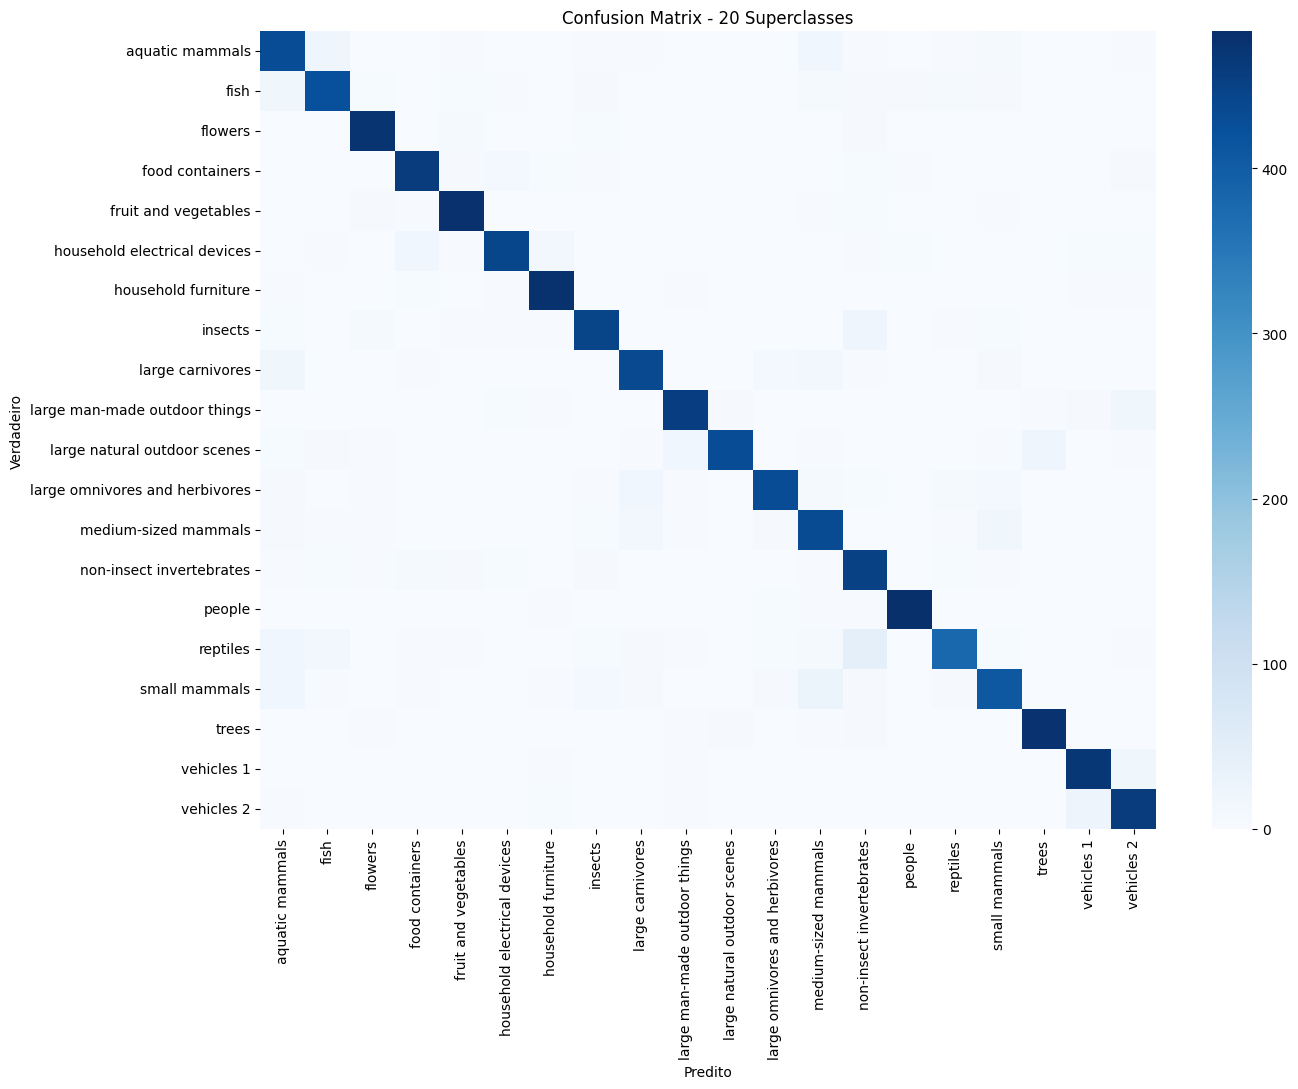

In [51]:
plt.figure(figsize=(14, 11))
cm_20 = confusion_matrix(true_20, preds_20)
sns.heatmap(cm_20, annot=False, cmap="Blues",
            xticklabels=superclass_names_20, yticklabels=superclass_names_20)
plt.title("Confusion Matrix - 20 Superclasses")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/cifar100_results/cm_20_superclasses.png")
plt.show()


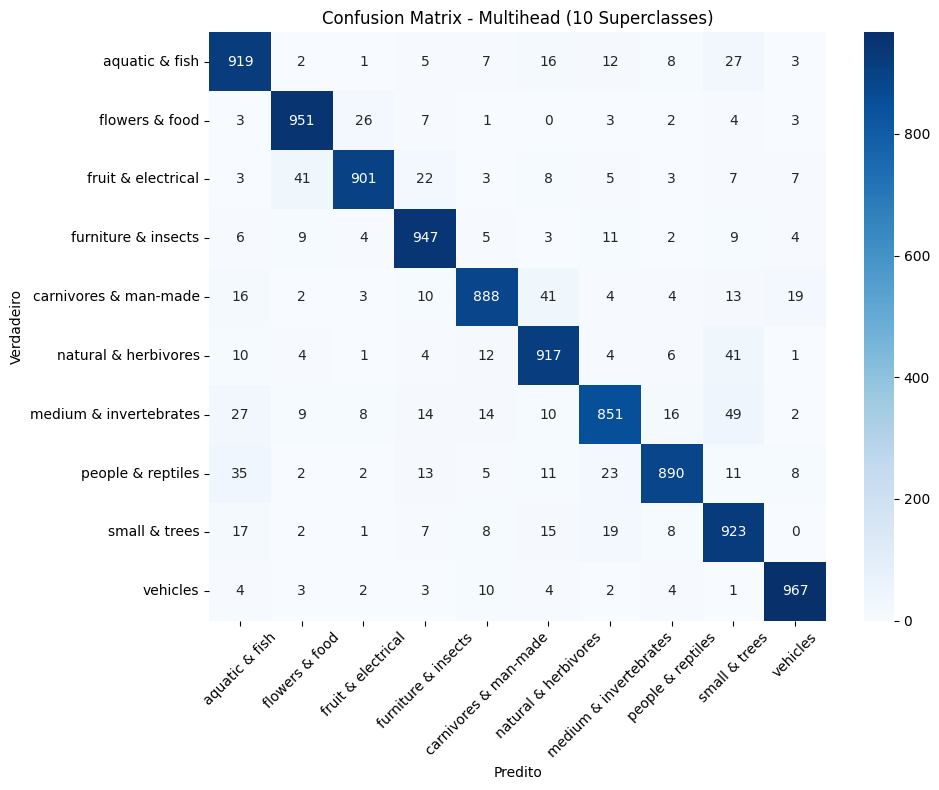

In [52]:

plt.figure(figsize=(10, 8))
cm_10 = confusion_matrix(true_10, preds_10)
sns.heatmap(cm_10, annot=True, fmt='d', cmap="Blues",
            xticklabels=superclass_names_10, yticklabels=superclass_names_10)
plt.title("Confusion Matrix - Multihead (10 Superclasses)")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/cifar100_results/cm_10_superclasses.png")
plt.show()

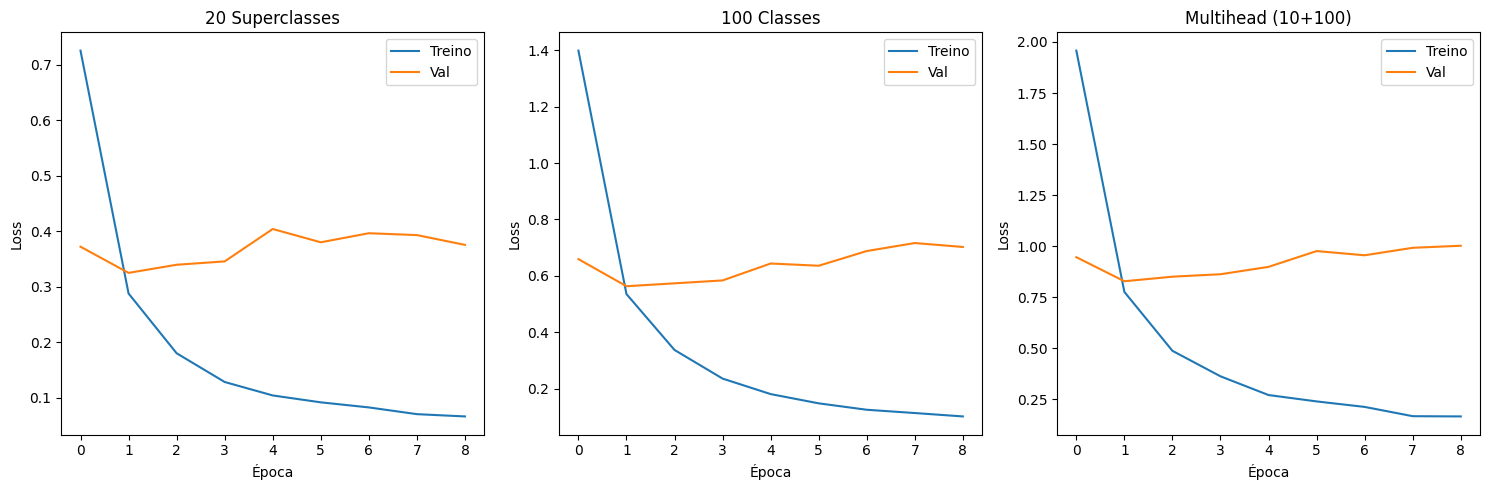


TODOS OS RESULTADOS SALVOS EM /content/drive/MyDrive/cifar100_results/


In [53]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(hist_20['train'], label='Treino')
plt.plot(hist_20['val'], label='Val')
plt.title('20 Superclasses')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(hist_100['train'], label='Treino')
plt.plot(hist_100['val'], label='Val')
plt.title('100 Classes')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(hist_multi['train'], label='Treino')
plt.plot(hist_multi['val'], label='Val')
plt.title('Multihead (10+100)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/cifar100_results/loss_curves.png")
plt.show()

print("\nTODOS OS RESULTADOS SALVOS EM /content/drive/MyDrive/cifar100_results/")

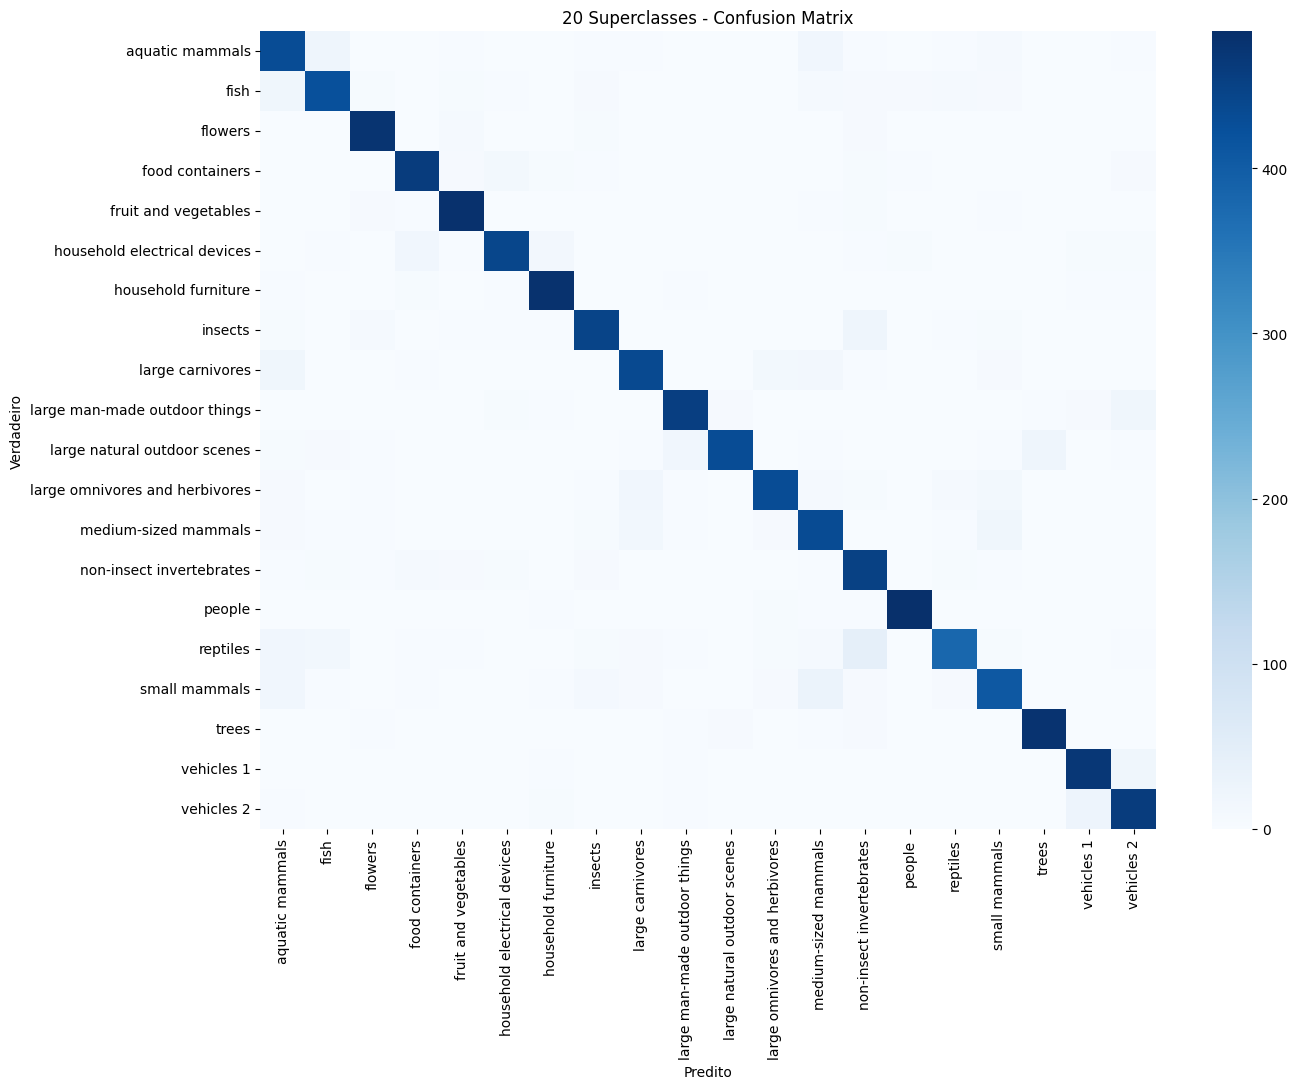

In [54]:
plt.figure(figsize=(14, 11))
sns.heatmap(confusion_matrix(true_20, preds_20), annot=False, cmap="Blues",
            xticklabels=superclass_names_20, yticklabels=superclass_names_20)
plt.title("20 Superclasses - Confusion Matrix")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/cifar100_results/cm_20_final.png", dpi=200)
plt.show()

In [56]:
!zip -r /content/cifar100_resultados.zip /content/drive/MyDrive/cifar100_results/
from google.colab import files
files.download('/content/cifar100_resultados.zip')

  adding: content/drive/MyDrive/cifar100_results/ (stored 0%)
  adding: content/drive/MyDrive/cifar100_results/cm_10_final.png (deflated 13%)
  adding: content/drive/MyDrive/cifar100_results/cm_20_superclasses.png (deflated 19%)
  adding: content/drive/MyDrive/cifar100_results/cm_20_final.png (deflated 22%)
  adding: content/drive/MyDrive/cifar100_results/loss_curves.png (deflated 9%)
  adding: content/drive/MyDrive/cifar100_results/cm_10_superclasses.png (deflated 12%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>